In [1]:
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.gpmodelling import GPModelling
from mind_the_gaps.models.psd_models import BendingPowerlaw, Lorentzian, SHO, Matern32, Jitter
from mind_the_gaps.models import Lorentzian as Lor
from mind_the_gaps.models.celerite.celerite_models import DampedRandomWalk
from mind_the_gaps.simulator import Simulator
import numpy as np
import matplotlib.pyplot as plt
import celerite, corner
from scipy.stats import percentileofscore
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)

cpus = 10 # set the number of cores for parallelization
np.random.seed(10)



/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Case of No period

# Define parameters for lightcurve simulation

In [2]:
times  = np.arange(0, 1000)
dt = np.diff(times)[0]

mean = 100

#A = (mean * 0.1) ** 2 # variance of the lorentzian
#Q = 80
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw

# define the PSD model
psd_model = BendingPowerlaw(variance_drw, w_bend) 

# Simulate lightcurve

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0, 0.5, 'Rates (ct/s)')

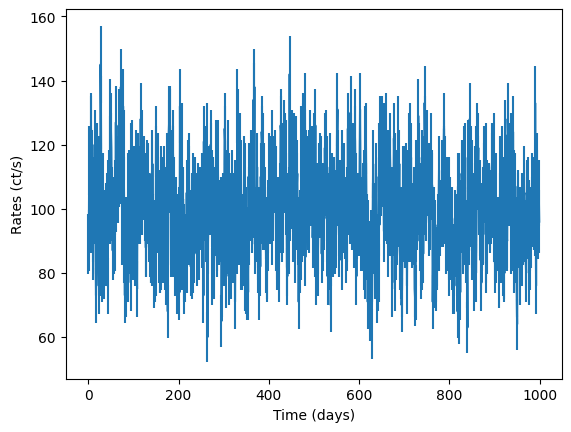

In [3]:
# create simulator object
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", 
                     extension_factor=2)
# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)

input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

Deriving posteriors for null model


  8%|▊         | 4000/50000 [00:10<02:04, 370.17it/s]


Convergence reached after 4000 samples!


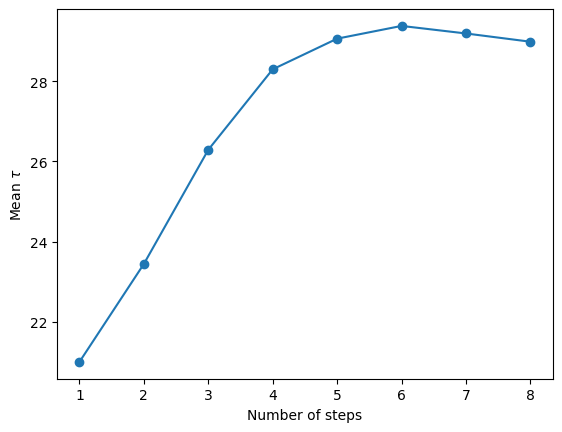

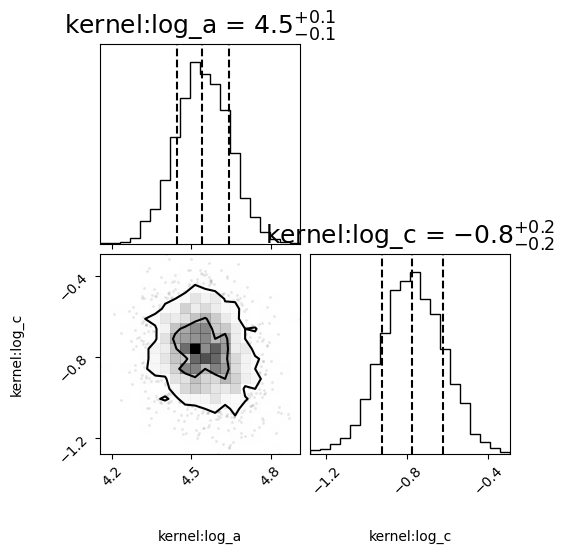

In [4]:
# null 
bounds_drw = dict(log_a=(-10, 50), log_c=(-10, 10))
# you can use RealTerm from celerite or DampedRandomWalk from models.celerite_models
#null_kernel = celerite.terms.RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend), bounds=bounds_drw)
null_kernel_spec =  KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            )
        ],
    )
null_model = GPModelling(kernel_spec=null_kernel_spec,lightcurve=input_lc,fit_mean=False)
print("Deriving posteriors for null model")
null_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)
null_model.plot_autocorrelation()
null_model.corner_plot_samples()


# Define alternative model

log variance of the QPO: 4.61, log_c: -5.54, log omega: -0.46
Deriving posteriors for alternative model


 50%|█████     | 25000/50000 [01:30<01:30, 276.45it/s]


Convergence reached after 25000 samples!


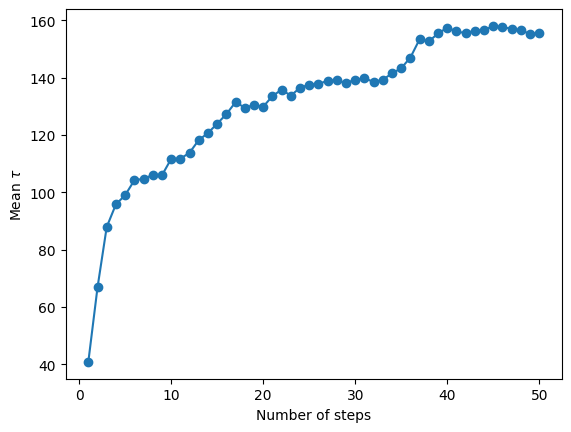

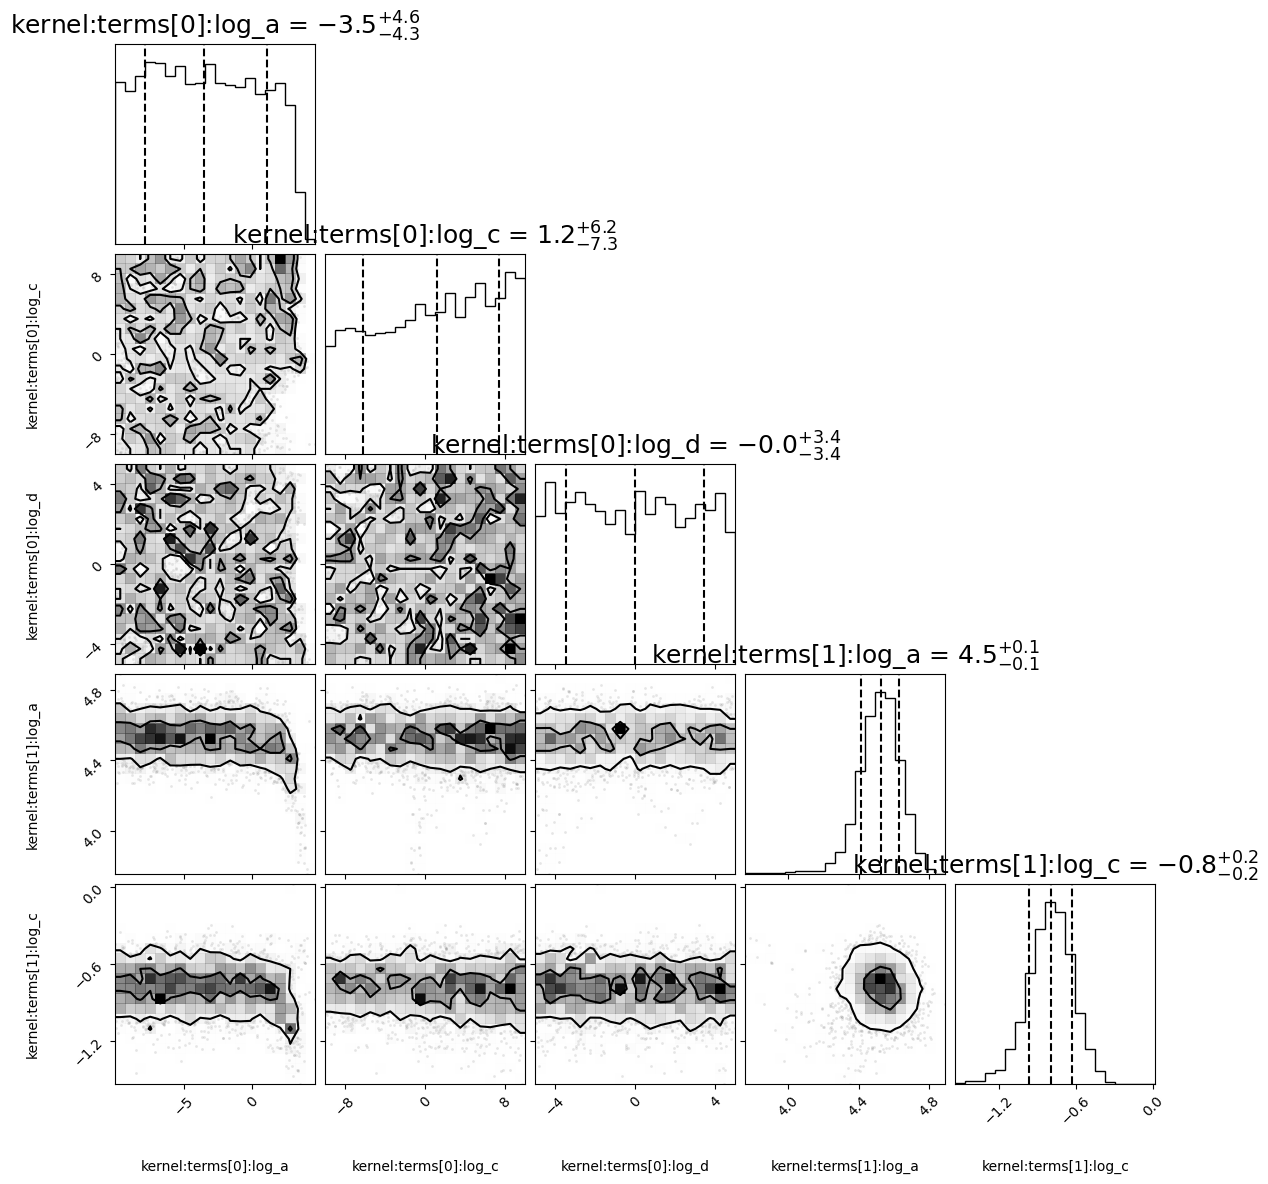

In [30]:
P = 10 # period of the QPO
w = 2 * np.pi / P
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
Q = 80 # coherence
log_c = np.log(0.5 * w/Q)
log_d = np.log(w)
print(f"log variance of the QPO: {log_variance_qpo:.2f}, log_c: {log_c:.2f}, log omega: {log_d:.2f}")

bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# You can also use Lorentzian from models.celerite_models (which is defined in terms of variance, Q and omega)
alternative_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.ComplexTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=log_variance_qpo, bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(value=log_c, bounds=(-10, 10)),
                    "log_d": KernelParameterSpec(value=log_d, bounds=(-5, 5)),
                },
            ),
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            ),
        ],
    )

alternative_model = GPModelling(kernel_spec=alternative_spec,lightcurve=input_lc,fit_mean=False)
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

alternative_model.plot_autocorrelation()
alternative_model.corner_plot_samples()




# Generate lightcurves from null hypothesis posteriors

In [32]:
nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(nsims=nsims)
print("Done!")

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/

Done!


# Fit the lightcurves with both null and alternative models

In [1]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(kernel_spec=null_kernel_spec,lightcurve=lc, fit_mean=False)
    null_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, progress=False)
    likelihoods_null.append(null_modelling.max_loglikelihood)
    alternative_modelling = GPModelling(kernel_spec=alternative_spec,lightcurve=lc, fit_mean=False)                         
    alternative_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, 
                                            progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikelihood)
    
                                                                              
print("\nDone!")

NameError: name 'lcs' is not defined

# Calculate T_LRT distribution and compare with the observed value

In [ ]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikelihood - alternative_model.max_loglikelihood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)

We see the p-value to reject the null hypothesis is fairly low, indicating there is no signal in this data, as expected

# Case with Period

# Simulate lightcurve

In [9]:
times  = np.arange(0, 500)
dt = np.diff(times)[0]

mean = 100

P = 10 # period of the QPO
w_qpo = 2 * np.pi / P
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
variance_qpo = variance_drw # let's assume same variance for the QPO and the DRW

Q = 80 # coherence

psd_model = Lorentzian(variance_qpo, Q, w_qpo) + BendingPowerlaw(variance_drw, w_bend) 

Text(0, 0.5, 'Rates (ct/s)')

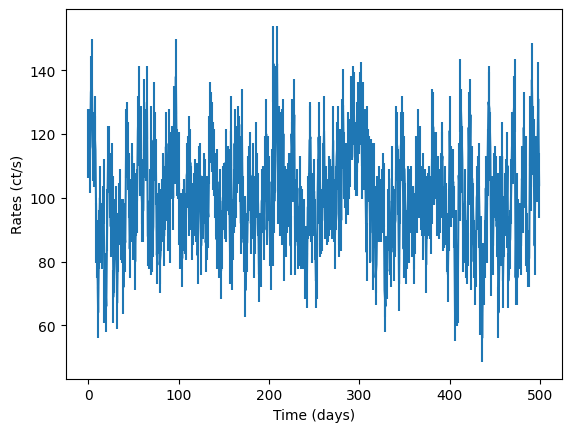

In [35]:
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", max_iter=500)

rates = simulator.generate_lightcurve()
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

Deriving posteriors for null model


 20%|██        | 10000/50000 [00:24<01:37, 410.13it/s]


Convergence reached after 10000 samples!


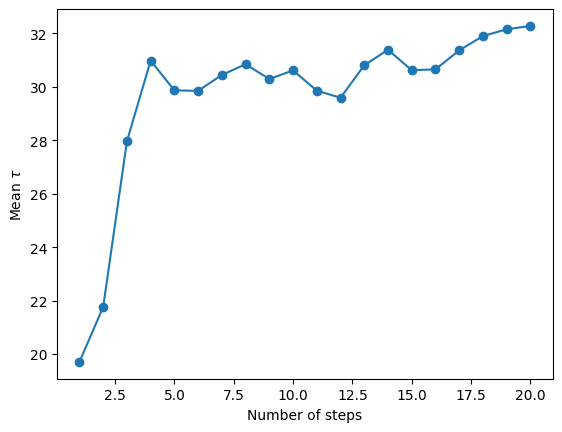

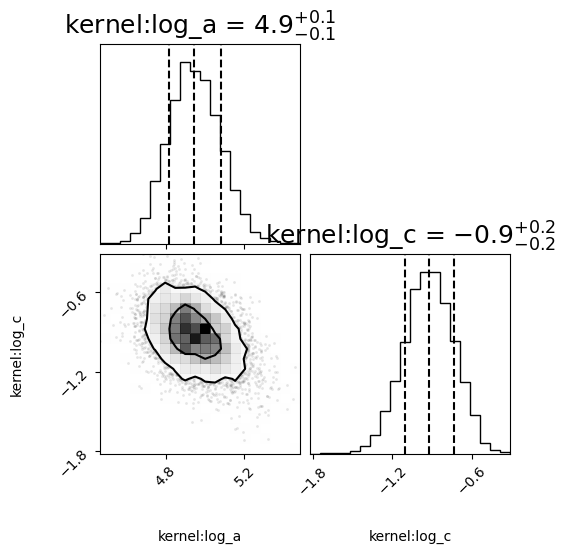

In [36]:

null_kernel_spec =  KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            )
        ],
    )
null_model = GPModelling(kernel_spec=null_kernel_spec,lightcurve=input_lc, fit_mean=False)
print("Deriving posteriors for null model")
null_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)
null_model.plot_autocorrelation("autocorrelation.png")
null_model.corner_plot_samples()


# Define alternative model

Deriving posteriors for alternative model


 59%|█████▉    | 29500/50000 [01:58<01:22, 249.30it/s]


Convergence reached after 29500 samples!


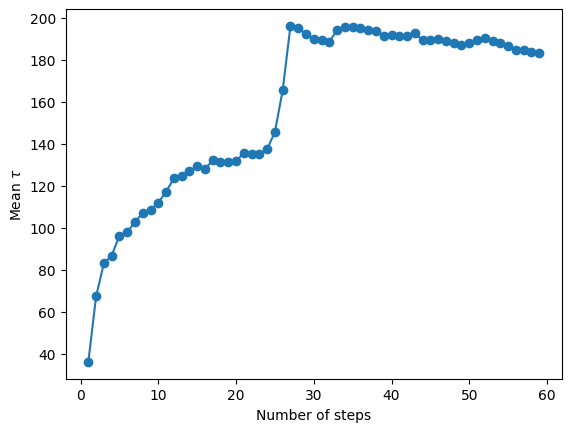

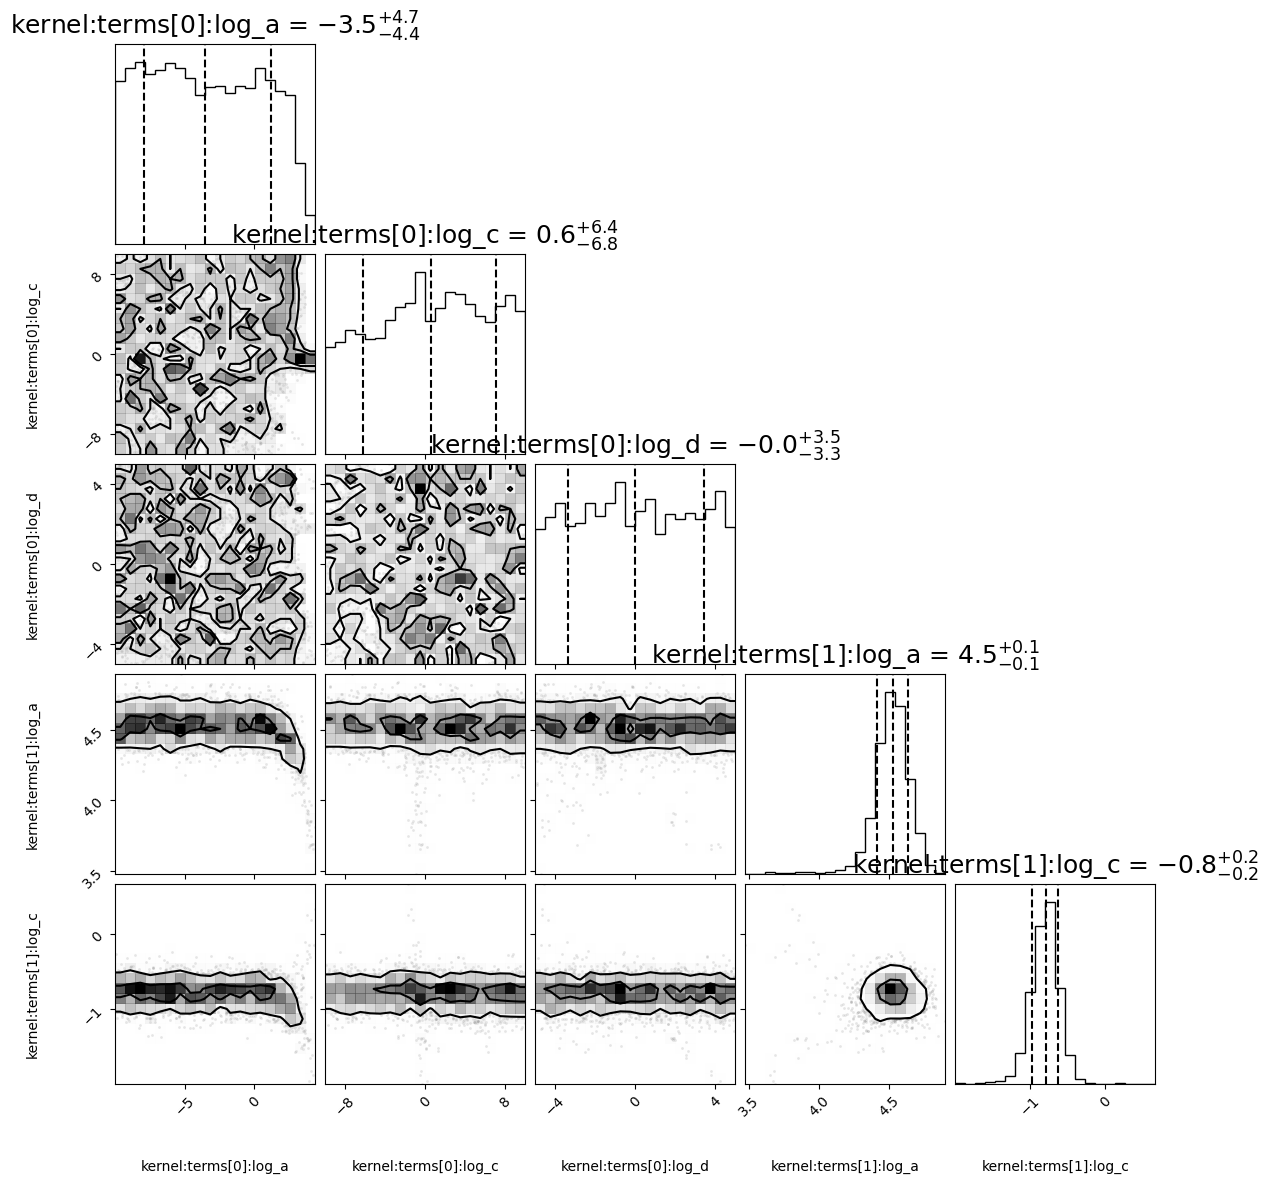

In [10]:
log_c = np.log(0.5 * w_qpo/Q)
log_d = np.log(w_qpo)
bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# again you may use the Lorentzian from models.celerite_models

alternative_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=celerite.terms.ComplexTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_qpo), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(value=log_c, bounds=(-10, 10)),
                    "log_d": KernelParameterSpec(value=log_d, bounds=(-5, 5)),
                },
            ),
            KernelTermSpec(
                term_class=celerite.terms.RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(
                        value=np.log(w_bend), bounds=(-10, 10)
                    ),
                },
            ),
        ],
    )
alternative_model = GPModelling(lightcurve=input_lc, kernel_spec=alternative_spec, fit_mean=False)
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

alternative_model.plot_autocorrelation()
alternative_model.corner_plot_samples()



# Generate lightcurves with null hypothesis posteriors

In [ ]:
nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(nsims=nsims)
print("Done!")

# Fit the lightcurves with both null and alternative models

In [ ]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    #fig = plt.figure()
    #plt.errorbar(lc.times, lc.y, lc.dy)
    #plt.xlabel("Time (days)")
    #plt.ylabel("Rate (ct/s)")
    #plt.savefig("%d.png" % i, dpi=100)
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(kernel_spec=null_kernel_spec,lightcurve=lc, fit_mean=False)
    null_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, progress=False)
    likelihoods_null.append(null_modelling.max_loglikelihood)
    alternative_modelling = GPModelling(kernel_spec=alternative_spec,lightcurve=lc, fit_mean=False)                         
    alternative_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, 
                                            progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikelihood)
    
                                                                              
print("\nDone!")

# Calculate T_LRT distribution and compare with the observed value

In [ ]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikelihood - alternative_model.max_loglikelihood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)